# Projet 4 : Anticipez les besoins en consommation de bâtiments

## Problématique
- Je travaille pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle confie à notre équipe une mission qui s'intéresse de près à la consommation d'énergie et aux émissions de CO2 des bâtiments non destinés à l'habitation. Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir.
<br>
<br>
- Missions :
> A partir de ces relevés déjà réalisés, nous voulons tenter de prédire les émissions de CO2 et la consommation totale d'énergie de bâtiments non destinés à **l'habitation** pour lesquels elles n'ont pas encore été mesurées.

# I. Analyse exploratoire des données

### Importation des modules python et du jeu de données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable
from sklearn.impute import KNNImputer

In [14]:
# Import the dataset
seattle_data = pd.read_csv("2016_Building_Energy_Benchmarking.csv")
seattle_data.sample(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1984,24045,2016,Multifamily LR (1-4),Low-Rise Multifamily,Clarke Apartments,950 N 72nd,Seattle,WA,98103.0,3362400870,...,2.412170e+05,823032.0,0.000000,0.0,False,NaN,Compliant,NaN,5.74,0.14
2704,26681,2016,NonResidential,Small- and Mid-Sized Office,(ID#26681) RAVENNA OFFICE BLDG,444 NE RAVENNA BLVD,Seattle,WA,98115.0,9528103705,...,2.922401e+05,997123.0,4049.250244,404925.0,False,NaN,Compliant,NaN,28.46,0.50
471,633,2016,NonResidential,Large Office,83 S KING ST BLDG (ID633),83 S KING ST,Seattle,WA,98104.0,7666206895,...,2.849616e+06,9722889.0,0.000000,0.0,False,NaN,Compliant,NaN,67.78,0.37
191,300,2016,SPS-District K-12,K-12 School,Cleveland STEM High,5511 15th Ave. S.,Seattle,WA,98108.0,7549802085,...,1.327294e+06,4528726.0,36620.820310,3662082.0,True,NaN,Error - Correct Default Data,NaN,226.06,1.10
2995,27816,2016,NonResidential,Other,Son Shone Inn,1808 18th Ave,Seattle,WA,98122.0,5707500120,...,8.241150e+04,281188.0,9614.780273,961478.0,False,NaN,Compliant,NaN,53.02,2.10


In [15]:
# All the informations of the data
seattle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

### Traitement des valeurs manquantes

In [16]:
# Description of the number/rate of missing values for each variable
seattle_data.stb.missing(style=True)

,missing,total,percent
Comments,"3,376","3,376",100.00%
Outlier,"3,344","3,376",99.05%
YearsENERGYSTARCertified,"3,257","3,376",96.48%
ThirdLargestPropertyUseType,"2,780","3,376",82.35%
ThirdLargestPropertyUseTypeGFA,"2,780","3,376",82.35%
SecondLargestPropertyUseType,"1,697","3,376",50.27%
SecondLargestPropertyUseTypeGFA,"1,697","3,376",50.27%
ENERGYSTARScore,843,"3,376",24.97%
LargestPropertyUseTypeGFA,20,"3,376",0.59%
LargestPropertyUseType,20,"3,376",0.59%


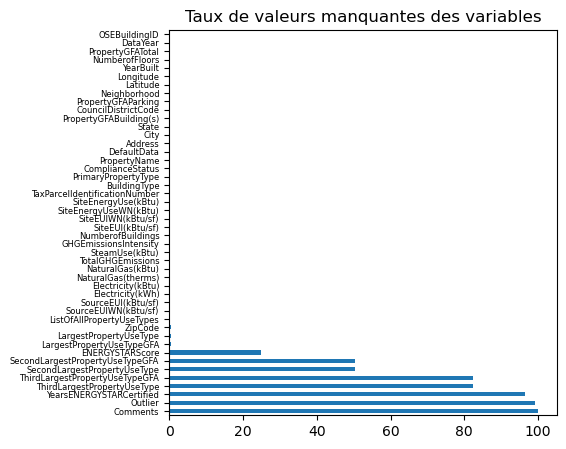

In [17]:
# Plotting of the rate of na values for all features 
plt.figure(figsize=(5,5))
(
(seattle_data.isnull()
 .mean(axis=0)*100)
 .sort_values(ascending=False)
 .plot(kind='barh', 
      title="Taux de valeurs manquantes des variables")
)
plt.yticks(fontsize=6)
plt.show()

- La plupart des variables contiennent très peu ou pas de valeurs manquantes.
<br>

- Nous allons supprimer les caractéristiques qui sont remplies de valeurs manquantes à plus de 80% sauf la variable Outlier qui nous permettra de distinguer les valeurs abérrantes et de pouvoir les traiter.

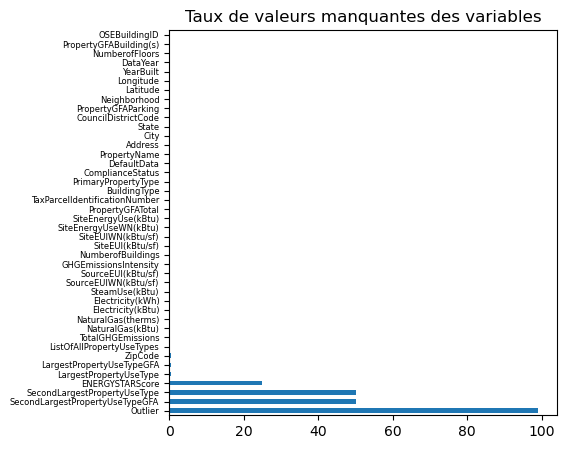

In [18]:
# Drop columns where 80+% of values are nan(exept the Outlier column) :

cols_to_drop = ["Comments","YearsENERGYSTARCertified","ThirdLargestPropertyUseType","ThirdLargestPropertyUseTypeGFA"]

# The cleaned dataset we keep
seattle_data = seattle_data.drop(axis=1, columns=cols_to_drop)

# Plotting of the rate of na values for all features 
plt.figure(figsize=(5,5))
(
(seattle_data.isnull()
 .mean(axis=0)*100)
 .sort_values(ascending=False)
 .plot(kind='barh', 
      title="Taux de valeurs manquantes des variables")
)
plt.yticks(fontsize=6)
plt.show()

- On voit maintenant que les variables sont assez bien remplies et le taux de valeurs manquantes est partout très petit excepté pour la variable Outlier.

### Traitement des valeurs abérrantes(Outliers)

- la variable Outlier nous donne ces informations : Si une propriété est une valeur aberrante élevée ou faible (O/N).

In [19]:
# Outlier feature
seattle_data.stb.freq(["Outlier"],style=True)

,Outlier,count,percent,cumulative_count,cumulative_percent
0,Low outlier,23,71.88%,23,71.88%
1,High outlier,9,28.12%,32,100.00%


- Nous avons 23 valeurs abérrantes faibles et 9 valeurs abérrantes élevées. Nous avons décidé de les supprimer ci-dessous dans l'étude.

In [20]:
# We keep only buildings where the Outlier value is null and we drop the Outlier feature
seattle_data = seattle_data.loc[seattle_data.Outlier.isnull()]
seattle_data = seattle_data.drop("Outlier",axis=1).reset_index(drop=True)
seattle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344 entries, 0 to 3343
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3344 non-null   int64  
 1   DataYear                         3344 non-null   int64  
 2   BuildingType                     3344 non-null   object 
 3   PrimaryPropertyType              3344 non-null   object 
 4   PropertyName                     3344 non-null   object 
 5   Address                          3344 non-null   object 
 6   City                             3344 non-null   object 
 7   State                            3344 non-null   object 
 8   ZipCode                          3328 non-null   float64
 9   TaxParcelIdentificationNumber    3344 non-null   object 
 10  CouncilDistrictCode              3344 non-null   int64  
 11  Neighborhood                     3344 non-null   object 
 12  Latitude            

### Analyse descriptive 

#### Analyse univariée

In [21]:
# A function to visualize the distribution of numerical features
def univariate_analysis(data,list_of_cols):
    
    for column in list_of_cols:
        print(f"""Description et analyse univariée de la variable {column} : 
        mean : {round(data[column].mean(),3)}
        std : {round(data[column].std(),3)}
        median : {round(data[column].quantile(0.5),3)}
        quartile q1: {round(data[column].quantile(0.25),3)}
        quartile q3 : {round(data[column].quantile(0.75),3)}
        min : {round(data[column].min(),3)}
        max : {round(data[column].max(),3)}""")
        
        
        # Distribution
        plt.figure(figsize=(5,5))
        sns.displot(data[column], kde = True)
        plt.title(f'Distribution de la variable {column}')
        plt.show()
        
        
        # Boxplot
        plt.figure(figsize=(5,5))
        sns.boxplot(x=column, data = data)
        plt.title(f'Boite à moustache de la variable {column}')
        plt.show()    
        
        print("\n")
        
        

Description et analyse univariée de la variable OSEBuildingID : 
        mean : 21188.289
        std : 12229.773
        median : 23108.5
        quartile q1: 19989.5
        quartile q3 : 25992.5
        min : 1
        max : 50226


<Figure size 500x500 with 0 Axes>

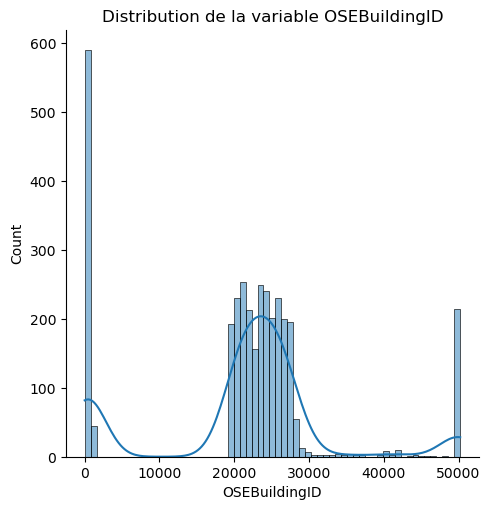

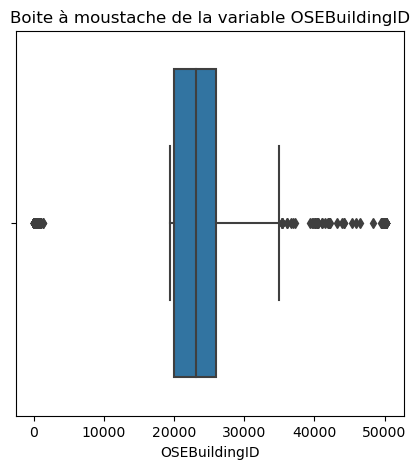



Description et analyse univariée de la variable DataYear : 
        mean : 2016.0
        std : 0.0
        median : 2016.0
        quartile q1: 2016.0
        quartile q3 : 2016.0
        min : 2016
        max : 2016


<Figure size 500x500 with 0 Axes>

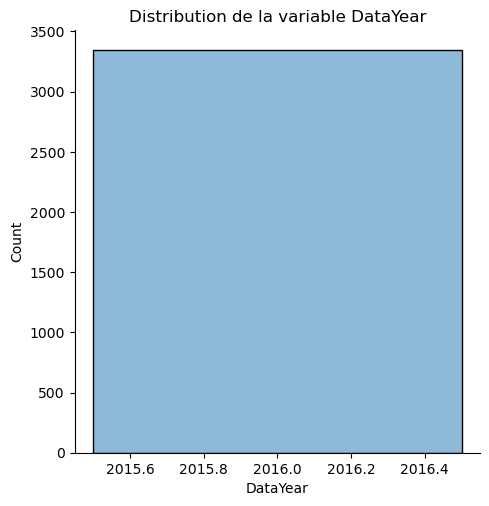

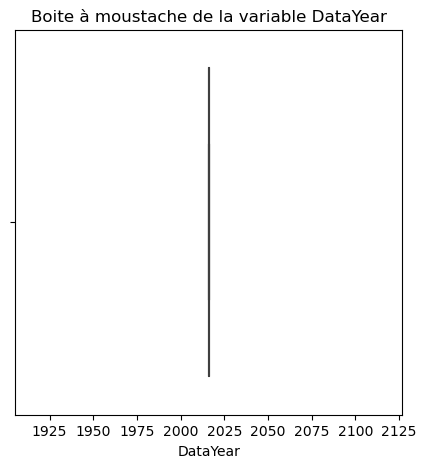



Description et analyse univariée de la variable ZipCode : 
        mean : 98116.984
        std : 18.673
        median : 98115.0
        quartile q1: 98105.0
        quartile q3 : 98122.0
        min : 98006.0
        max : 98272.0


<Figure size 500x500 with 0 Axes>

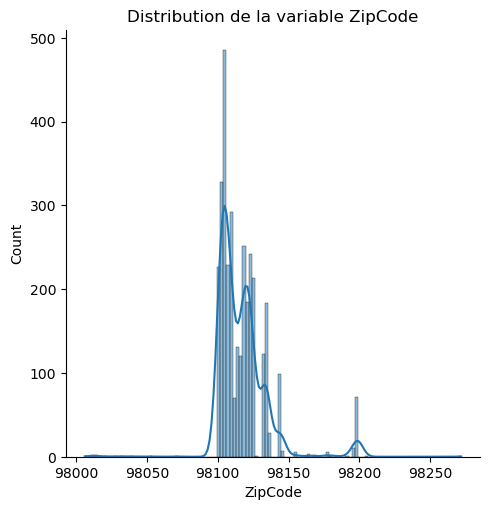

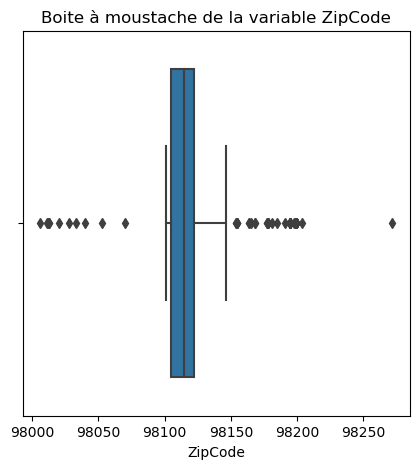



Description et analyse univariée de la variable CouncilDistrictCode : 
        mean : 4.445
        std : 2.118
        median : 4.0
        quartile q1: 3.0
        quartile q3 : 7.0
        min : 1
        max : 7


<Figure size 500x500 with 0 Axes>

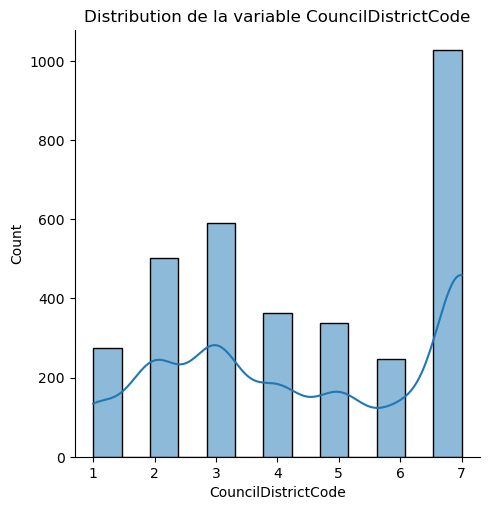

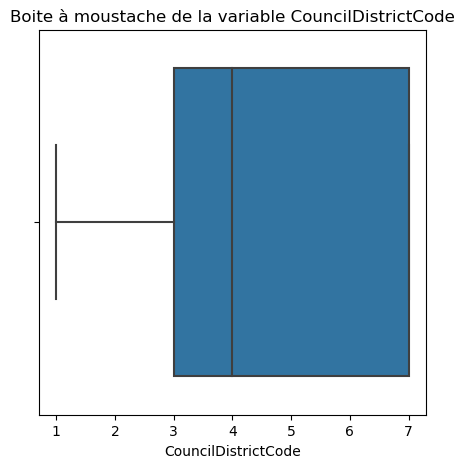



Description et analyse univariée de la variable Latitude : 
        mean : 47.624
        std : 0.048
        median : 47.619
        quartile q1: 47.6
        quartile q3 : 47.657
        min : 47.499
        max : 47.734


<Figure size 500x500 with 0 Axes>

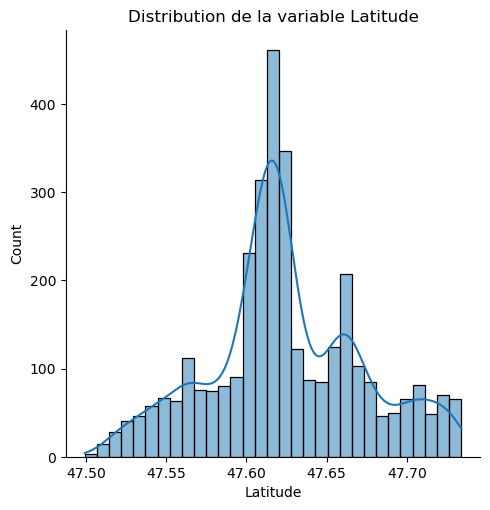

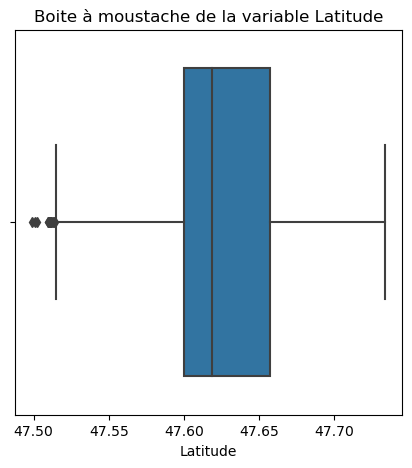



Description et analyse univariée de la variable Longitude : 
        mean : -122.335
        std : 0.027
        median : -122.332
        quartile q1: -122.351
        quartile q3 : -122.319
        min : -122.414
        max : -122.221


<Figure size 500x500 with 0 Axes>

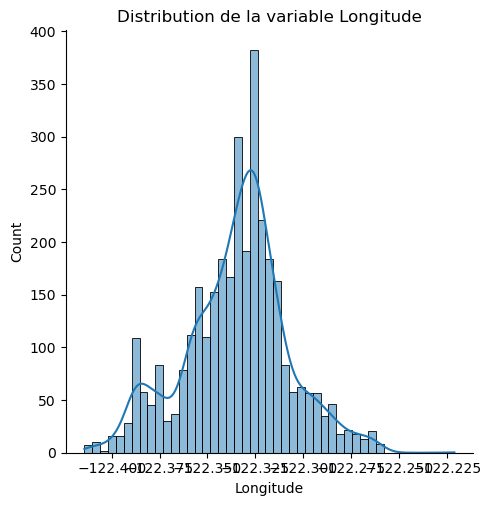

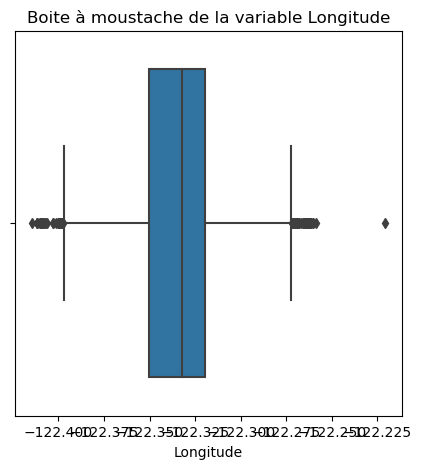



Description et analyse univariée de la variable YearBuilt : 
        mean : 1968.746
        std : 33.005
        median : 1975.0
        quartile q1: 1948.75
        quartile q3 : 1997.0
        min : 1900
        max : 2015


<Figure size 500x500 with 0 Axes>

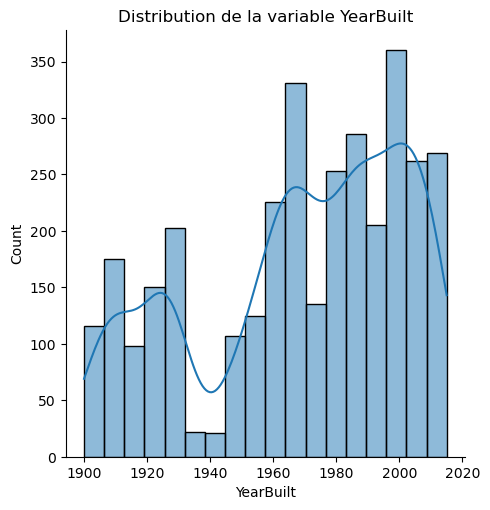

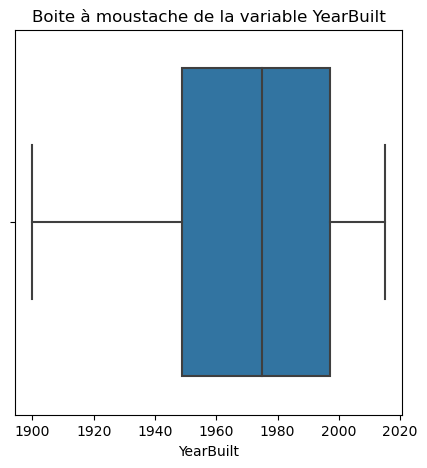



Description et analyse univariée de la variable NumberofBuildings : 
        mean : 1.106
        std : 2.117
        median : 1.0
        quartile q1: 1.0
        quartile q3 : 1.0
        min : 0.0
        max : 111.0


<Figure size 500x500 with 0 Axes>

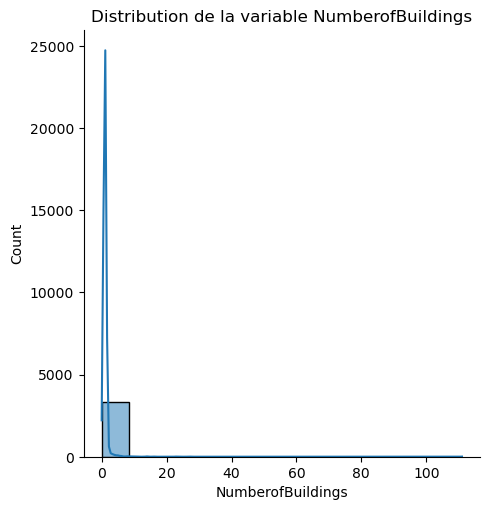

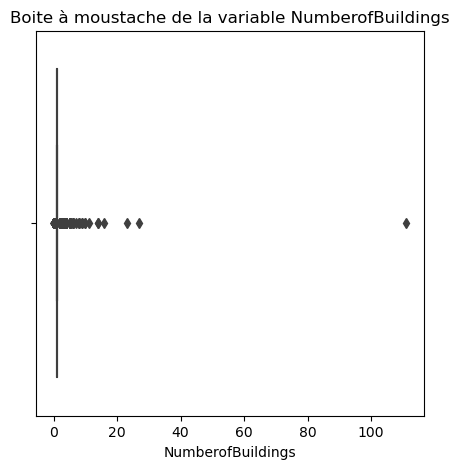



Description et analyse univariée de la variable NumberofFloors : 
        mean : 4.715
        std : 5.507
        median : 4.0
        quartile q1: 2.0
        quartile q3 : 5.0
        min : 0
        max : 99


<Figure size 500x500 with 0 Axes>

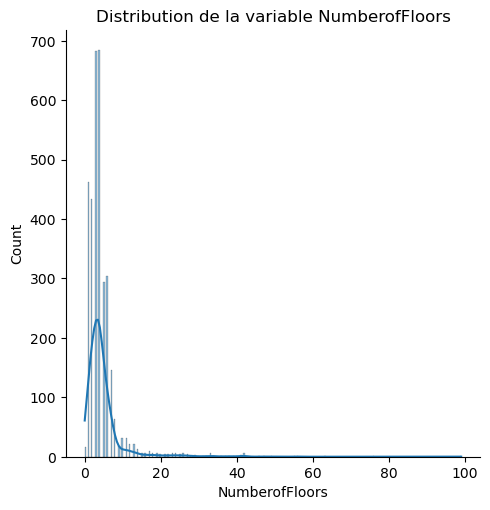

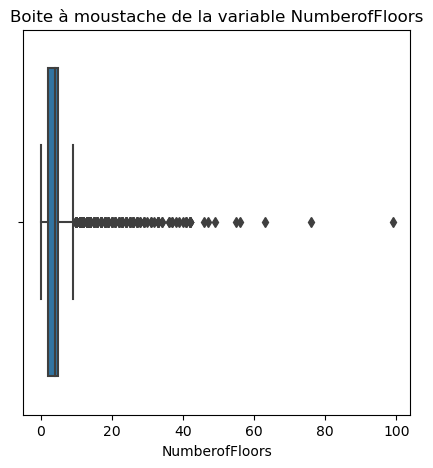



Description et analyse univariée de la variable PropertyGFATotal : 
        mean : 95226.647
        std : 219806.067
        median : 44291.0
        quartile q1: 28523.25
        quartile q3 : 91150.75
        min : 11285
        max : 9320156


<Figure size 500x500 with 0 Axes>

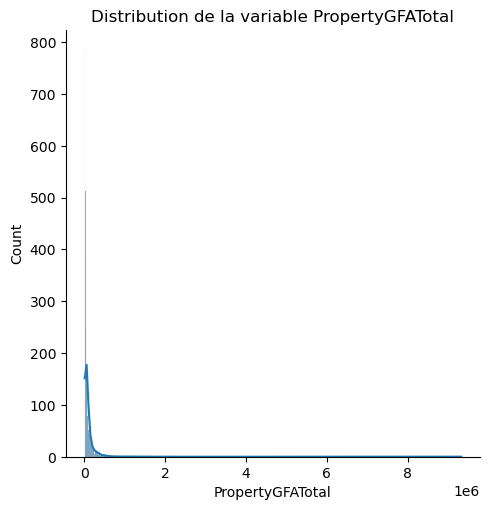

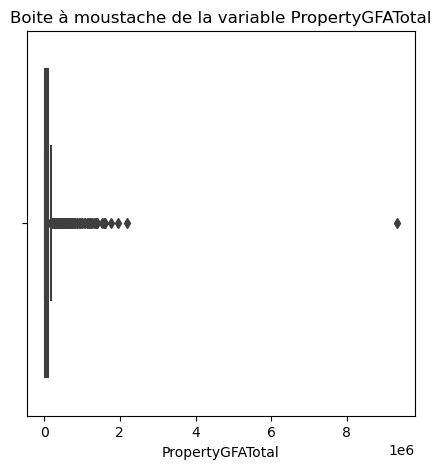



Description et analyse univariée de la variable PropertyGFAParking : 
        mean : 8053.131
        std : 32465.292
        median : 0.0
        quartile q1: 0.0
        quartile q3 : 0.0
        min : 0
        max : 512608


<Figure size 500x500 with 0 Axes>

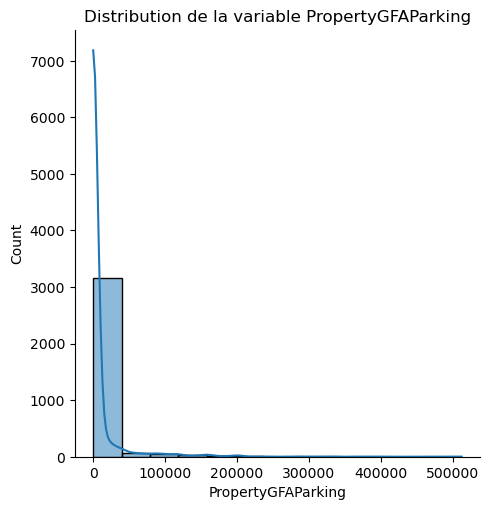

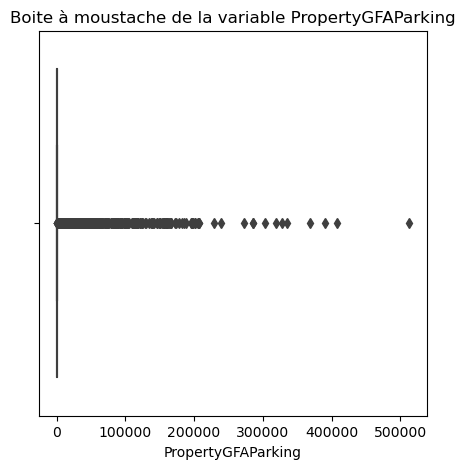



Description et analyse univariée de la variable PropertyGFABuilding(s) : 
        mean : 87173.516
        std : 208868.795
        median : 43228.0
        quartile q1: 27791.0
        quartile q3 : 84416.25
        min : 3636
        max : 9320156


<Figure size 500x500 with 0 Axes>

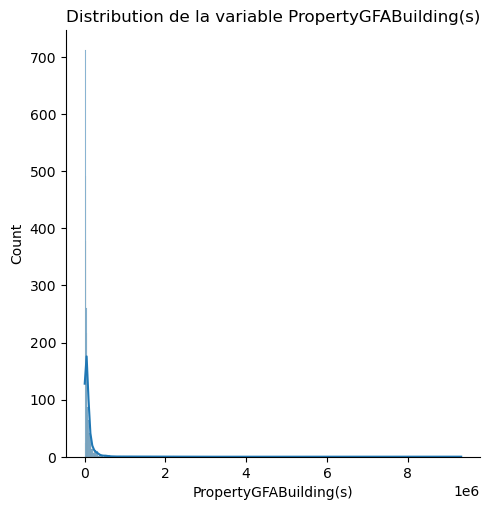

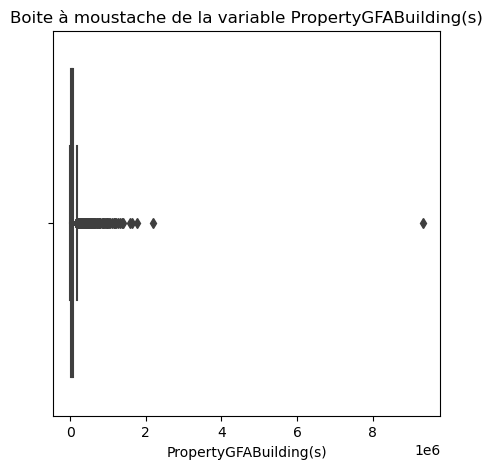



Description et analyse univariée de la variable LargestPropertyUseTypeGFA : 
        mean : 79489.685
        std : 202610.71
        median : 39961.0
        quartile q1: 25150.75
        quartile q3 : 76766.75
        min : 5656.0
        max : 9320156.0


<Figure size 500x500 with 0 Axes>

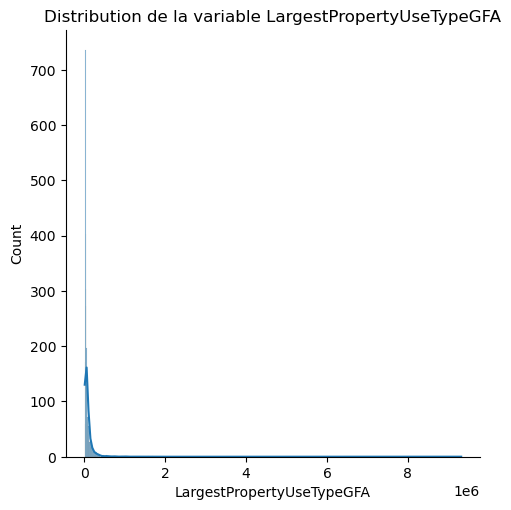

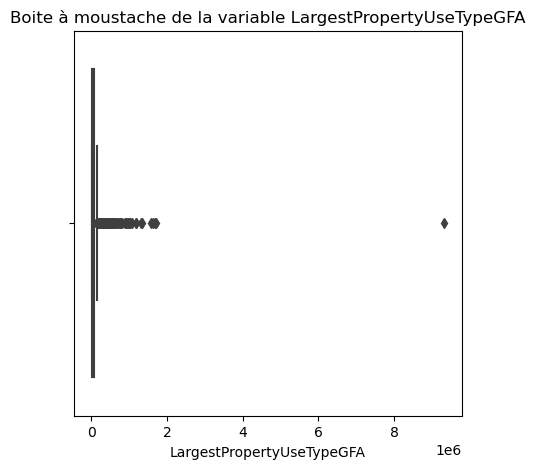



Description et analyse univariée de la variable SecondLargestPropertyUseTypeGFA : 
        mean : 28556.826
        std : 54587.821
        median : 10751.0
        quartile q1: 5000.0
        quartile q3 : 26770.0
        min : 0.0
        max : 686750.0


<Figure size 500x500 with 0 Axes>

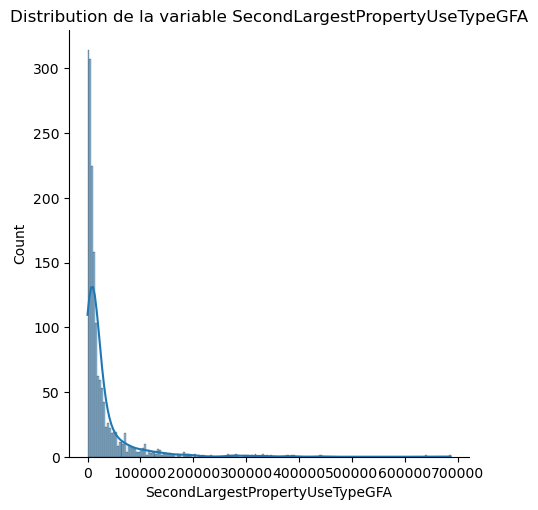

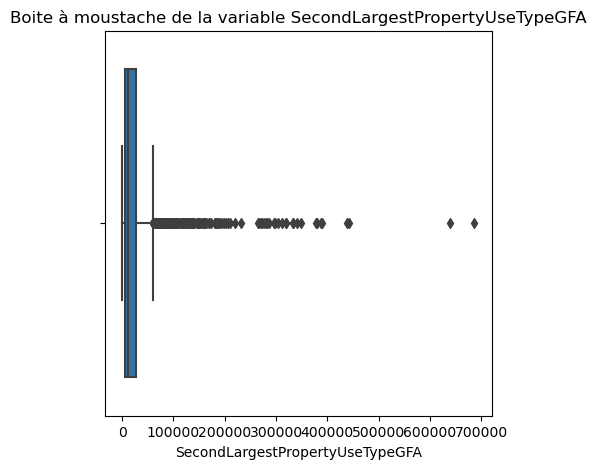



Description et analyse univariée de la variable ENERGYSTARScore : 
        mean : 67.829
        std : 26.708
        median : 75.0
        quartile q1: 53.0
        quartile q3 : 90.0
        min : 1.0
        max : 100.0


<Figure size 500x500 with 0 Axes>

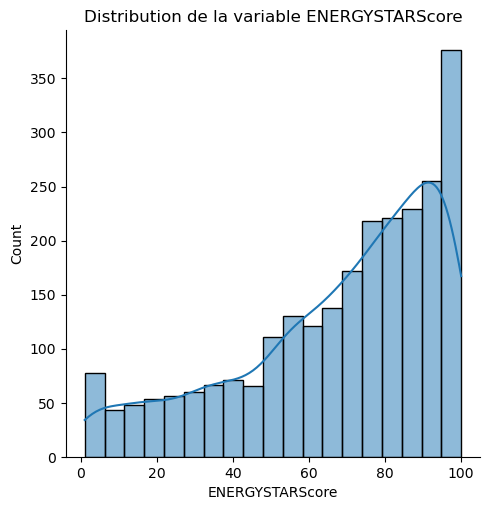

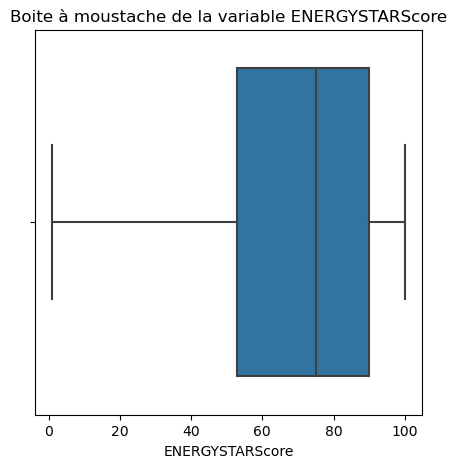



Description et analyse univariée de la variable SiteEUI(kBtu/sf) : 
        mean : 54.717
        std : 55.911
        median : 38.7
        quartile q1: 28.1
        quartile q3 : 60.4
        min : 0.0
        max : 834.4


<Figure size 500x500 with 0 Axes>

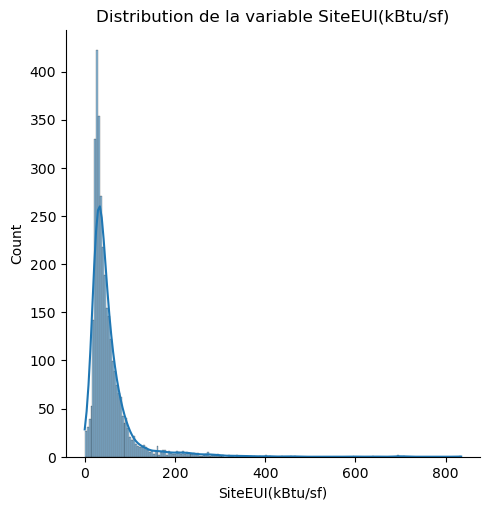

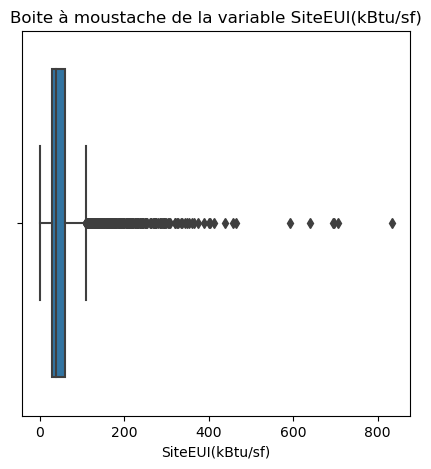



Description et analyse univariée de la variable SiteEUIWN(kBtu/sf) : 
        mean : 57.025
        std : 56.793
        median : 40.9
        quartile q1: 29.5
        quartile q3 : 64.2
        min : 0.0
        max : 834.4


<Figure size 500x500 with 0 Axes>

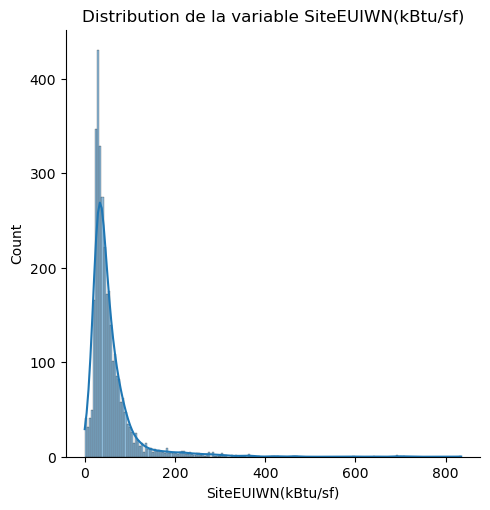

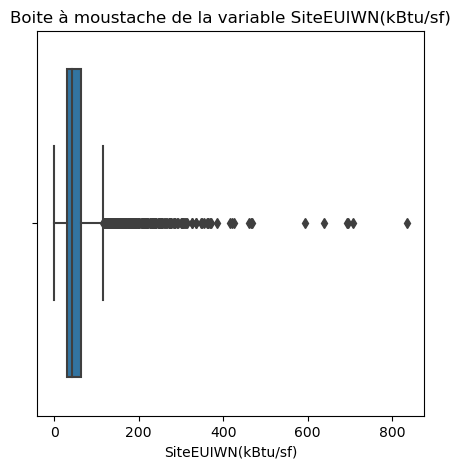



Description et analyse univariée de la variable SourceEUI(kBtu/sf) : 
        mean : 134.185
        std : 137.785
        median : 96.4
        quartile q1: 75.0
        quartile q3 : 143.85
        min : 0.0
        max : 2620.0


<Figure size 500x500 with 0 Axes>

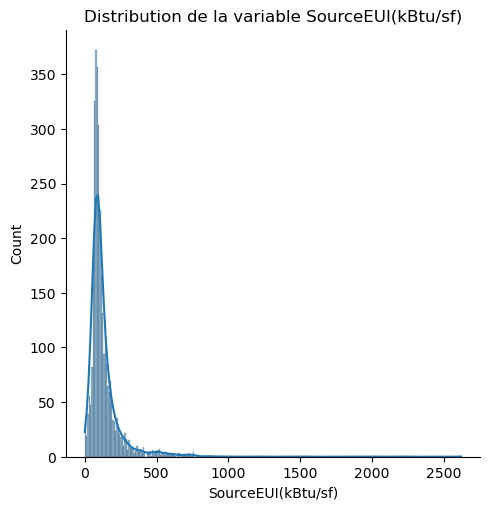

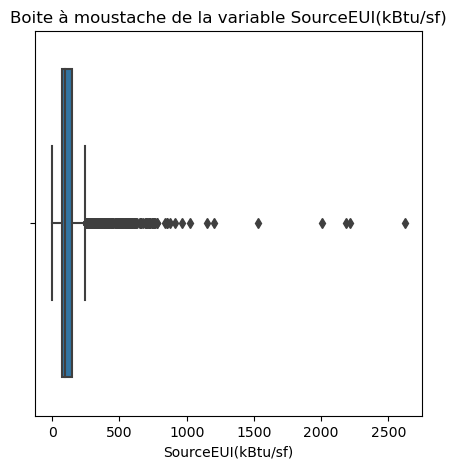



Description et analyse univariée de la variable SourceEUIWN(kBtu/sf) : 
        mean : 137.742
        std : 137.555
        median : 101.3
        quartile q1: 78.7
        quartile q3 : 148.3
        min : -2.1
        max : 2620.0


<Figure size 500x500 with 0 Axes>

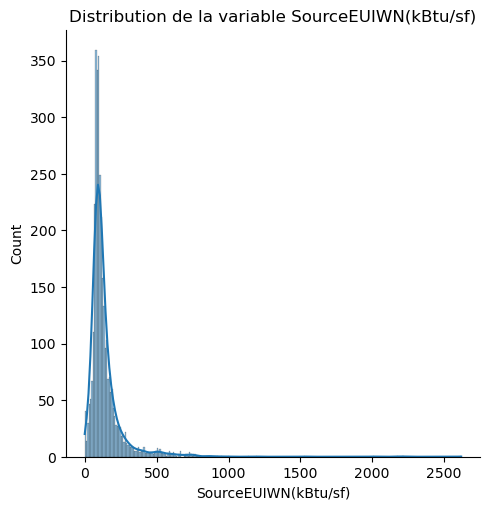

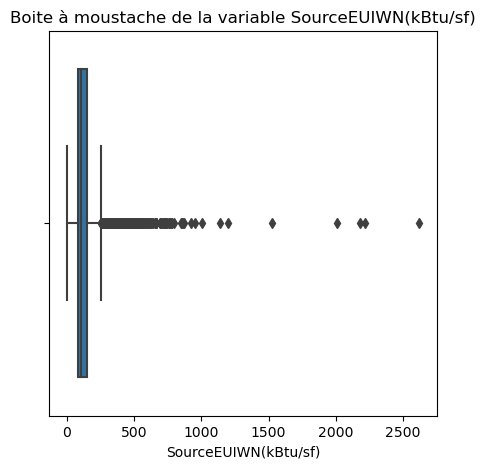



Description et analyse univariée de la variable SiteEnergyUse(kBtu) : 
        mean : 5414823.429
        std : 21696835.466
        median : 1809101.5
        quartile q1: 935188.781
        quartile q3 : 4218830.5
        min : 0.0
        max : 873923712.0


<Figure size 500x500 with 0 Axes>

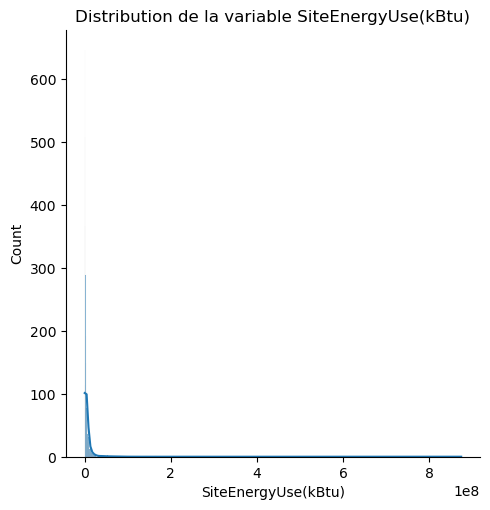

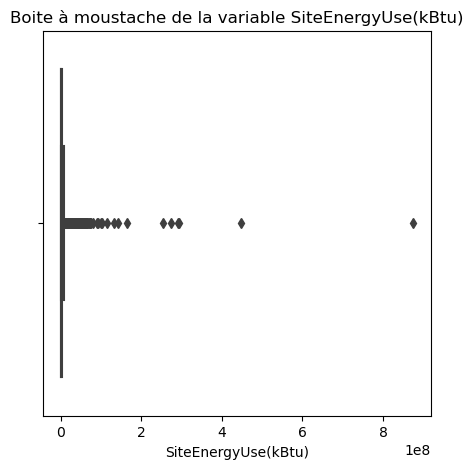



Description et analyse univariée de la variable SiteEnergyUseWN(kBtu) : 
        mean : 5285707.036
        std : 15991475.88
        median : 1914797.0
        quartile q1: 983237.891
        quartile q3 : 4379956.5
        min : 0.0
        max : 471613856.0


<Figure size 500x500 with 0 Axes>

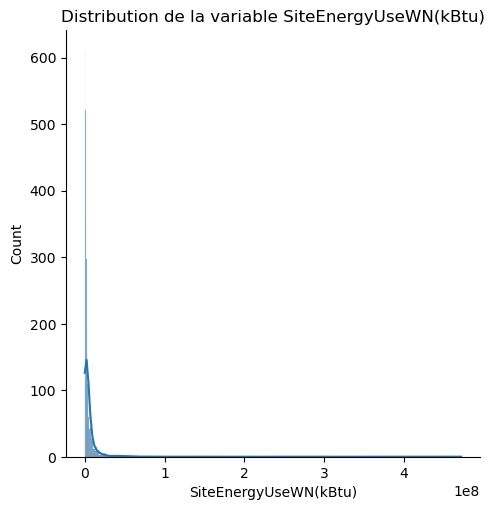

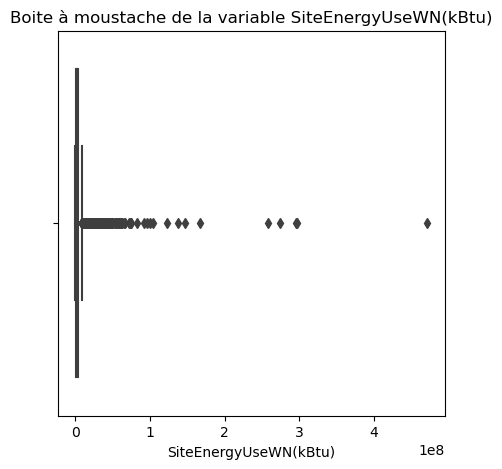



Description et analyse univariée de la variable SteamUse(kBtu) : 
        mean : 274620.628
        std : 3928101.822
        median : 0.0
        quartile q1: 0.0
        quartile q3 : 0.0
        min : 0.0
        max : 134943456.0


<Figure size 500x500 with 0 Axes>

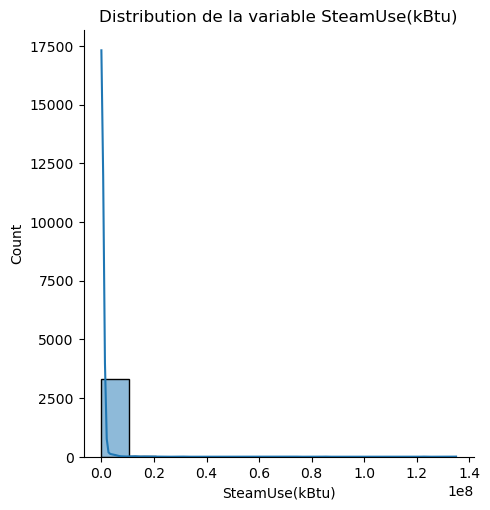

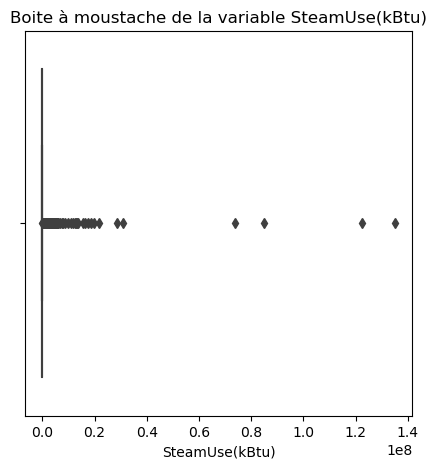



Description et analyse univariée de la variable Electricity(kWh) : 
        mean : 1088729.943
        std : 4366981.267
        median : 346729.812
        quartile q1: 188771.797
        quartile q3 : 831021.781
        min : -33826.801
        max : 192577488.0


<Figure size 500x500 with 0 Axes>

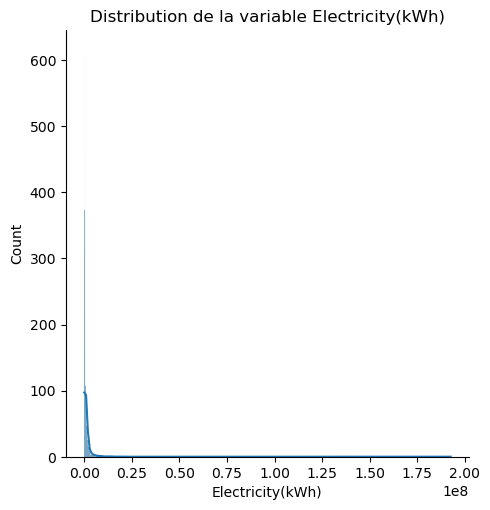

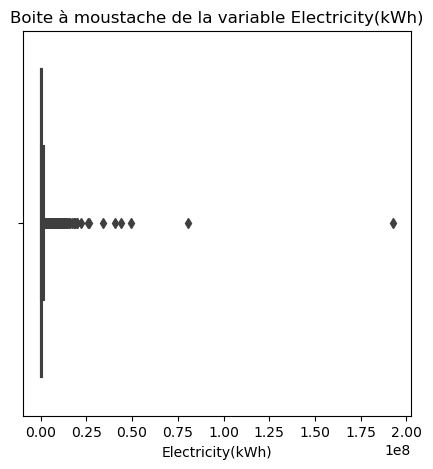



Description et analyse univariée de la variable Electricity(kBtu) : 
        mean : 3714746.573
        std : 14900140.073
        median : 1183042.0
        quartile q1: 644089.5
        quartile q3 : 2835446.0
        min : -115417.0
        max : 657074389.0


<Figure size 500x500 with 0 Axes>

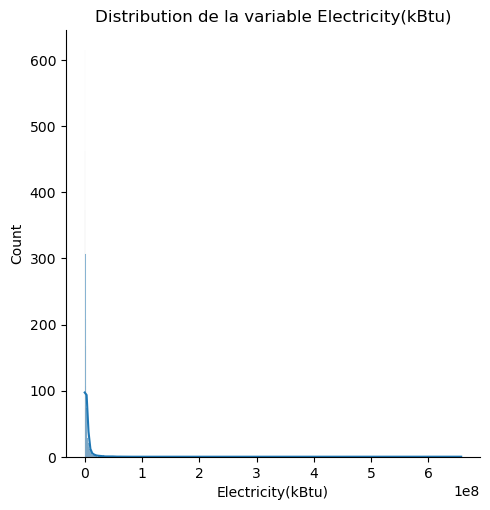

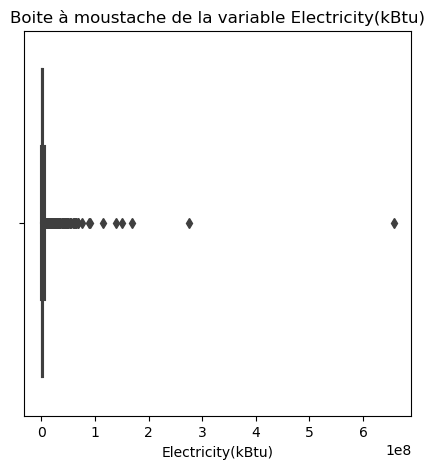



Description et analyse univariée de la variable NaturalGas(therms) : 
        mean : 13747.786
        std : 67390.791
        median : 3294.022
        quartile q1: 0.0
        quartile q3 : 11932.133
        min : 0.0
        max : 2979090.0


<Figure size 500x500 with 0 Axes>

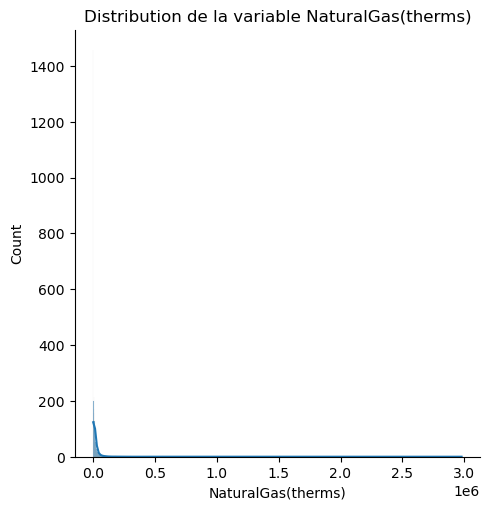

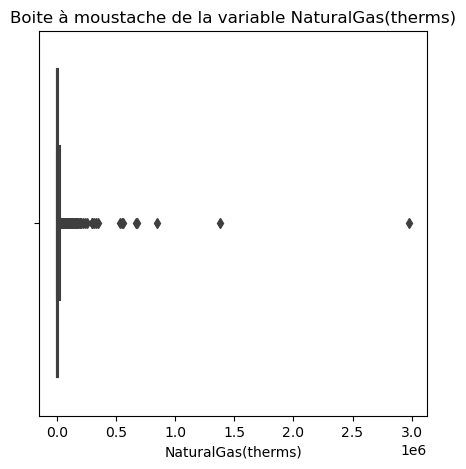



Description et analyse univariée de la variable NaturalGas(kBtu) : 
        mean : 1374778.652
        std : 6739079.113
        median : 329402.0
        quartile q1: 0.0
        quartile q3 : 1193213.5
        min : 0.0
        max : 297909000.0


<Figure size 500x500 with 0 Axes>

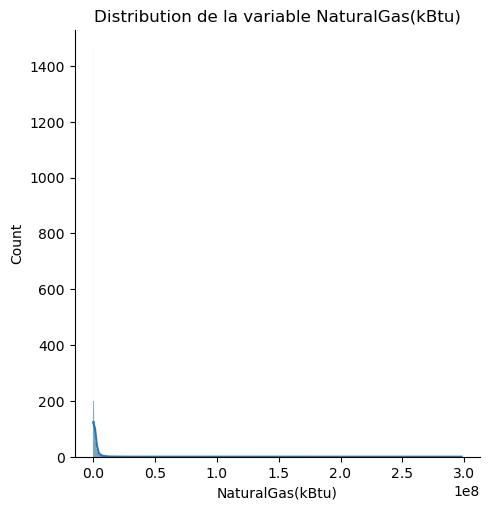

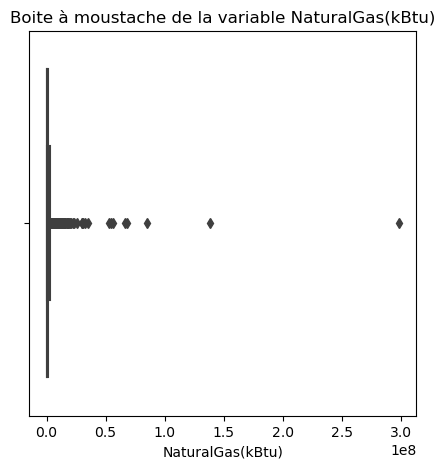



Description et analyse univariée de la variable TotalGHGEmissions : 
        mean : 120.109
        std : 541.164
        median : 34.11
        quartile q1: 9.655
        quartile q3 : 94.015
        min : -0.8
        max : 16870.98


<Figure size 500x500 with 0 Axes>

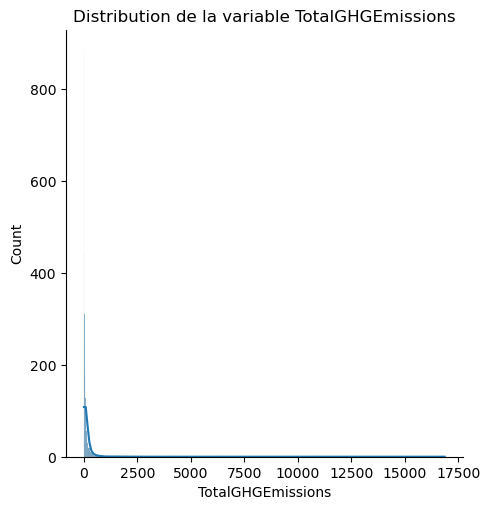

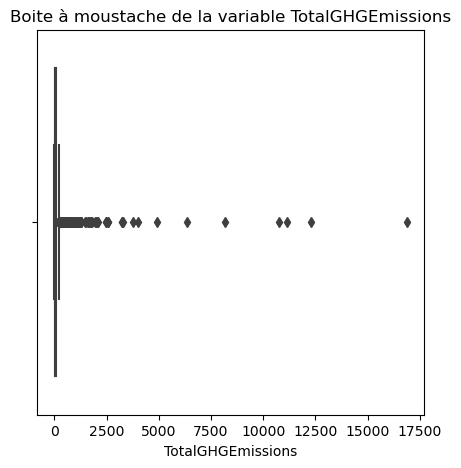



Description et analyse univariée de la variable GHGEmissionsIntensity : 
        mean : 1.175
        std : 1.813
        median : 0.62
        quartile q1: 0.21
        quartile q3 : 1.37
        min : -0.02
        max : 34.09


<Figure size 500x500 with 0 Axes>

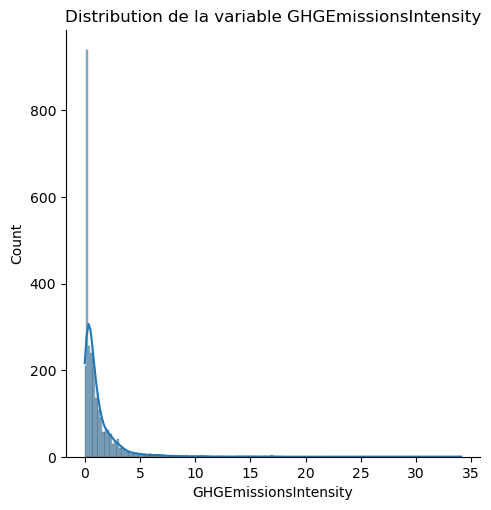

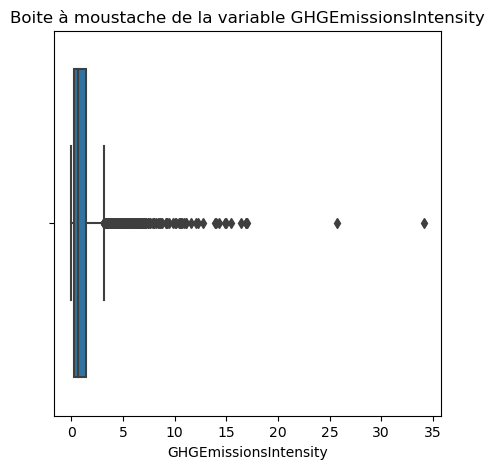

In [22]:
# Apply univariate visulisation to all numeric columns
numeric_columns = seattle_data.select_dtypes(include=['float64',"int64"]).columns
univariate_analysis(seattle_data,numeric_columns)

- Nous avons effectué une brève déscription statistique des variables quantitatives.
<br>
- La plupart des distributions ne sont pas bien représentées à cause de la plage de valeur des variables concernées.
<br>
- Nous envigaserons donc de transformer certaines caractéristiques en utilisant leurs logarithmes et/ou les mettre en échelle.

Description et analyse univariée du logarithme de la translation par 1 de la variable SiteEnergyUse(kBtu) :
          mean :5414823.429
          std : 21696835.466
          median : 1809101.5
          quartile q1: 935188.781
          quartile q3 : 4218830.5
          min : 0.0
          max : 873923712.0


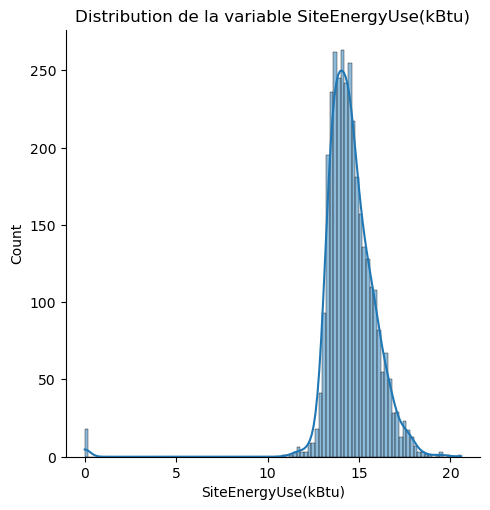



Description et analyse univariée du logarithme de la translation par 1 de la variable TotalGHGEmissions :
          mean :120.109
          std : 541.164
          median : 34.11
          quartile q1: 9.655
          quartile q3 : 94.015
          min : -0.8
          max : 16870.98


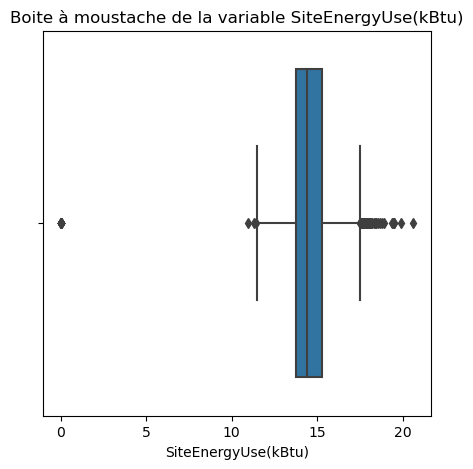

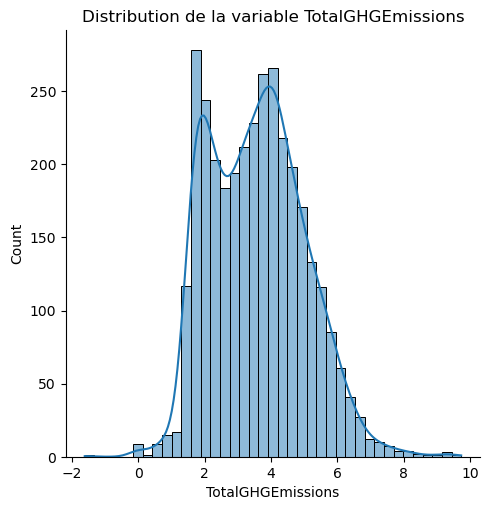



Description et analyse univariée du logarithme de la translation par 1 de la variable SiteEnergyUseWN(kBtu) :
          mean :5285707.036
          std : 15991475.88
          median : 1914797.0
          quartile q1: 983237.891
          quartile q3 : 4379956.5
          min : 0.0
          max : 471613856.0


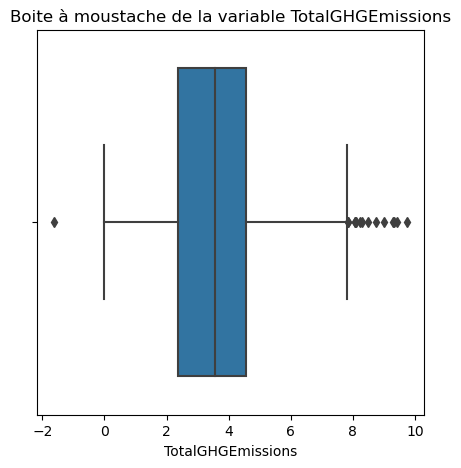

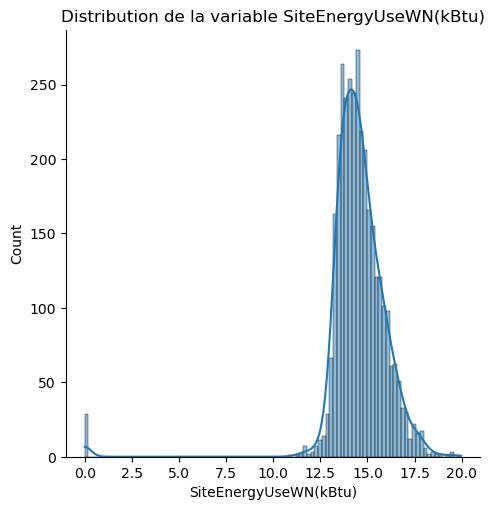



Description et analyse univariée du logarithme de la translation par 1 de la variable GHGEmissionsIntensity :
          mean :1.175
          std : 1.813
          median : 0.62
          quartile q1: 0.21
          quartile q3 : 1.37
          min : -0.02
          max : 34.09


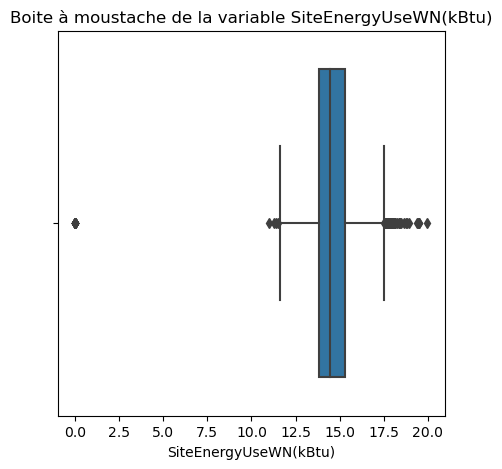

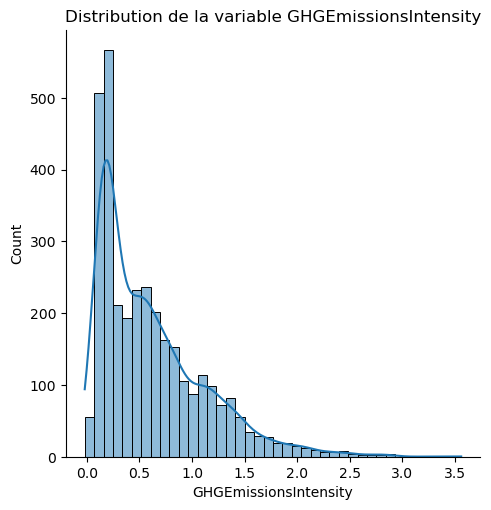

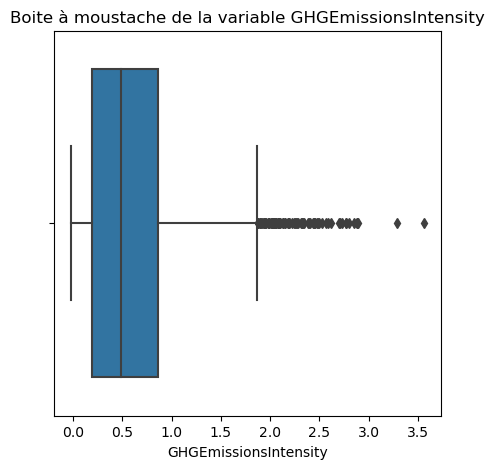

In [23]:
# Visualizing only target columns(Energy consommation and GHGEmissions)
target_columns = ['SiteEnergyUse(kBtu)','TotalGHGEmissions',"SiteEnergyUseWN(kBtu)","GHGEmissionsIntensity"]

# Statistical description the logzarithms of target features
for column in target_columns:
    print(f"""Description et analyse univariée du logarithme de la translation par 1 de la variable {column} :
          mean :{round(seattle_data[column].mean(),3)}
          std : {round(seattle_data[column].std(),3)}
          median : {round(seattle_data[column].quantile(0.5),3)}
          quartile q1: {round(seattle_data[column].quantile(0.25),3)}
          quartile q3 : {round(seattle_data[column].quantile(0.75),3)}
          min : {round(seattle_data[column].min(),3)}
          max : {round(seattle_data[column].max(),3)}""")
    sns.displot(data=np.log1p(seattle_data[column]),kde = True)
    plt.title(f'Distribution de la variable {column}')
    plt.show()
    
    # Boxplot
    plt.figure(figsize=(5,5))
    sns.boxplot(x=np.log1p(seattle_data[column]),data=seattle_data)
    plt.title(f'Boite à moustache de la variable {column}')
    
    
    print("\n")

- La transformation des variables target en prenant le logarithme de leurs translation par 1 permet d'avoir une meilleure visualisation des distributions statistiques. 
> Dans la suite, nous allons garder cette transformation logarithmique et c'est cette forme des targets que nous allons tenter de modéliser.

#### Analyse bivariée

In [27]:
seattle_data.select_dtypes(include=['int64','float64']).corr().describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,27.000000,0.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,...,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,-0.033523,NaN,-0.000511,0.085244,0.052379,0.038456,0.080964,0.243253,0.166148,0.365078,...,0.232718,0.427677,0.365789,0.241199,0.407413,0.407413,0.256509,0.256509,0.382231,0.219533
std,0.228664,NaN,0.205785,0.221370,0.215615,0.202649,0.199344,0.334844,0.236838,0.373941,...,0.352576,0.363331,0.308835,0.281277,0.361840,0.361840,0.307899,0.307899,0.334264,0.315940
min,-0.213765,NaN,-0.120971,-0.271237,-0.053711,-0.271237,-0.149377,-0.026741,-0.118222,-0.135869,...,-0.299282,-0.116870,-0.202152,-0.038705,-0.128461,-0.128461,-0.101404,-0.101404,-0.100697,-0.258418
25%,-0.128461,NaN,-0.061091,0.002867,-0.022228,0.009191,-0.002761,0.005658,0.002958,0.061906,...,0.031605,0.104878,0.079569,0.015746,0.116409,0.116409,0.029853,0.029853,0.062649,-0.018025
50%,-0.103506,NaN,-0.043774,0.054075,-0.016657,0.026923,0.038866,0.033249,0.079281,0.183361,...,0.100519,0.311824,0.392417,0.093185,0.291319,0.291319,0.183361,0.183361,0.405719,0.107923
75%,-0.003692,NaN,-0.029005,0.076071,0.010645,0.032469,0.096749,0.548591,0.272771,0.745445,...,0.289977,0.755840,0.586672,0.467665,0.714168,0.714168,0.339828,0.339828,0.687538,0.483887
max,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


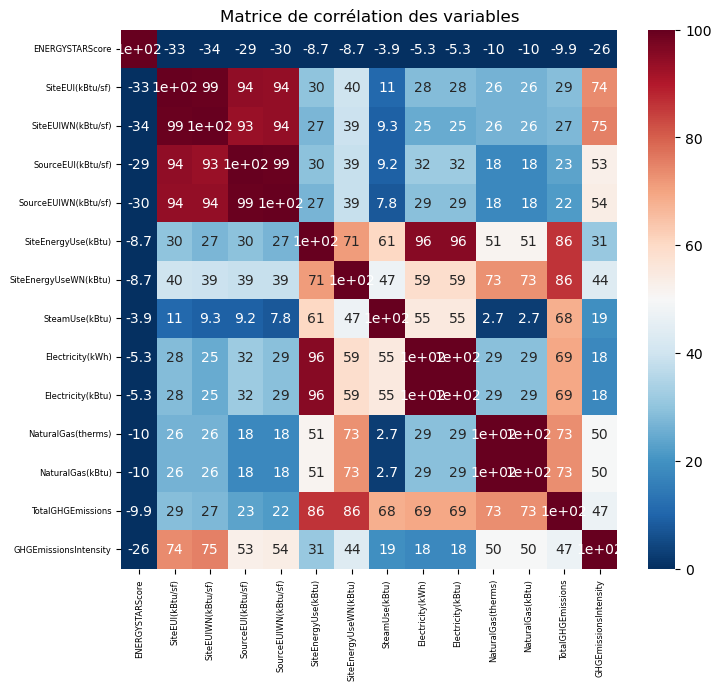

In [45]:
# Correlation matrix
corr_cols = ['ENERGYSTARScore', 'SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)',
                   'SourceEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','SteamUse(kBtu)','Electricity(kWh)',
                   'Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity']
plt.figure(figsize=(8,7))
correlation = seattle_data.loc[:,corr_cols].corr() * 100
sns.heatmap(correlation, cmap="RdBu_r",annot=True,vmin=0, vmax=100)
plt.title('Matrice de corrélation des variables')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

- TotalGHGEmissions est très fortement corrélée aux variables : NaturalGas(kBtu),NaturalGas(therms),Electricity(kBtu),Electricity(kWh),SteamUse(kBtu),SiteEnergyUseWN(kBtu),SiteEnergyUse(kBtu)
<br>
<br>
- De même, SiteEnergyUse(kBtu) est très fortement corrélée aux variables : TotalGHGEmissions,Electricity(kWh),Electricity(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu).

### Choix du type de batiments à garder

- L'objectif est de tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l'habitation pour lesquels elles n'ont pas encore été mesurées.
- Nous allons donc garder dans l'étude uniquement les batiments non habitables.
- Nous avons plusieurs caractéristiques qui nous donnent des informations sur le type de bâtiment concerné. Nous filtrons donc à travers l'une d'entre-elles pour garder ce qui nous intéresse, c'est-à-dire les batiments non déstinés à l'habitation.

In [13]:
# List Of All Property Use Types
seattle_data.stb.freq(["ListOfAllPropertyUseTypes"],style=True)

,ListOfAllPropertyUseTypes,count,percent,cumulative_count,cumulative_percent
0,Multifamily Housing,859,25.76%,859,25.76%
1,"Multifamily Housing, Parking",462,13.85%,"1,321",39.61%
2,Office,136,4.08%,"1,457",43.69%
3,K-12 School,133,3.99%,"1,590",47.68%
4,"Office, Parking",119,3.57%,"1,709",51.24%
5,Non-Refrigerated Warehouse,101,3.03%,"1,810",54.27%
6,"Non-Refrigerated Warehouse, Office",61,1.83%,"1,871",56.10%
7,Other,59,1.77%,"1,930",57.87%
8,Retail Store,55,1.65%,"1,985",59.52%
9,"Multifamily Housing, Retail Store",51,1.53%,"2,036",61.05%


In [14]:
# Primary Property Type = L'utilisation principale d'une propriété (par exemple, bureau, magasin de détail). 
                # L'usage principal est défini comme une fonction qui représente plus de 50 % d'un bien. 
                    #Il s'agit du champ Type de propriété - Calculé EPA de Portfolio Manager.
seattle_data.stb.freq(["PrimaryPropertyType"],style=True)

,PrimaryPropertyType,count,percent,cumulative_count,cumulative_percent
0,Low-Rise Multifamily,975,29.16%,975,29.16%
1,Mid-Rise Multifamily,561,16.78%,"1,536",45.93%
2,Small- and Mid-Sized Office,290,8.67%,"1,826",54.61%
3,Other,253,7.57%,"2,079",62.17%
4,Warehouse,187,5.59%,"2,266",67.76%
5,Large Office,170,5.08%,"2,436",72.85%
6,K-12 School,137,4.10%,"2,573",76.94%
7,Mixed Use Property,133,3.98%,"2,706",80.92%
8,High-Rise Multifamily,104,3.11%,"2,810",84.03%
9,Retail Store,89,2.66%,"2,899",86.69%


In [15]:
# Building Type = Classification des types de bâtiments de la ville de Seattle.
seattle_data.stb.freq(["BuildingType"],style=True)

,BuildingType,count,percent,cumulative_count,cumulative_percent
0,NonResidential,"1,445",43.21%,"1,445",43.21%
1,Multifamily LR (1-4),"1,006",30.08%,"2,451",73.30%
2,Multifamily MR (5-9),578,17.28%,"3,029",90.58%
3,Multifamily HR (10+),109,3.26%,"3,138",93.84%
4,SPS-District K-12,97,2.90%,"3,235",96.74%
5,Nonresidential COS,84,2.51%,"3,319",99.25%
6,Campus,24,0.72%,"3,343",99.97%
7,Nonresidential WA,1,0.03%,"3,344",100.00%


In [16]:
# Largest Property Use Type
seattle_data.stb.freq(["LargestPropertyUseType"],style=True) 

,LargestPropertyUseType,count,percent,cumulative_count,cumulative_percent
0,Multifamily Housing,"1,651",49.67%,"1,651",49.67%
1,Office,492,14.80%,"2,143",64.47%
2,Non-Refrigerated Warehouse,199,5.99%,"2,342",70.46%
3,K-12 School,137,4.12%,"2,479",74.58%
4,Other,99,2.98%,"2,578",77.56%
5,Retail Store,97,2.92%,"2,675",80.48%
6,Hotel,76,2.29%,"2,751",82.76%
7,Worship Facility,69,2.08%,"2,820",84.84%
8,Distribution Center,54,1.62%,"2,874",86.46%
9,Senior Care Community,46,1.38%,"2,920",87.85%


- Nous avons choisi d'utiliser la variable "LargestPropertyUseType" pour filtrer et ne garder que les bâtiments non destinés à l'habitation.

In [17]:
# We keep only non-habitable buildings.
seattle_data = seattle_data.loc[~(seattle_data.LargestPropertyUseType=="Multifamily Housing")]
seattle_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1693 entries, 0 to 3343
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1693 non-null   int64  
 1   DataYear                         1693 non-null   int64  
 2   BuildingType                     1693 non-null   object 
 3   PrimaryPropertyType              1693 non-null   object 
 4   PropertyName                     1693 non-null   object 
 5   Address                          1693 non-null   object 
 6   City                             1693 non-null   object 
 7   State                            1693 non-null   object 
 8   ZipCode                          1677 non-null   float64
 9   TaxParcelIdentificationNumber    1693 non-null   object 
 10  CouncilDistrictCode              1693 non-null   int64  
 11  Neighborhood                     1693 non-null   object 
 12  Latitude            

### Sélection des variables et jeu de données final pour la modélisation

- Dans le cadre de la sélection des variables d'entrainement de nos modèles de prédiction, nous supprimons les caractéristiques sur le type de batiment(qui nous ont déjà servi à choisir les batimentts non-habitables), les informations sur les adresses postales etc.. qui ne semblent pas pertinents par rapport à nos objectifs de prédiction.

In [18]:
# We now keep only meaningful columns for our machine learning tasks
meaningful_cols = ['NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)',
                   'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)',
                   'SourceEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','SteamUse(kBtu)','Electricity(kWh)',
                   'Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity']
seattle_data= seattle_data.loc[:,meaningful_cols]

# Description of the number/rate of missing values for each variable
seattle_data.stb.missing(style=True)

,missing,total,percent
ENERGYSTARScore,580,"1,693",34.26%
LargestPropertyUseTypeGFA,20,"1,693",1.18%
SourceEUIWN(kBtu/sf),9,"1,693",0.53%
SteamUse(kBtu),9,"1,693",0.53%
TotalGHGEmissions,9,"1,693",0.53%
NaturalGas(kBtu),9,"1,693",0.53%
NaturalGas(therms),9,"1,693",0.53%
Electricity(kBtu),9,"1,693",0.53%
Electricity(kWh),9,"1,693",0.53%
GHGEmissionsIntensity,9,"1,693",0.53%


- La plupart des variables sélectionnées sont assez bien remplies, elles contiennent très peu de valeurs manquantes(sauf la variable "ENERGYSTARScore" qui contient près de 35% de valeurs manquantes).
<br>
- Néanmoins, nous décidons de garder la variable "ENERGYSTARScore" dans l'étude dans un premier temps en remplissant les valeurs manquantes par la méthode des k-plus-proches voisins. Dans un second temps, nous l'enléverons tout simplement de l'étude.
<br>
<br>
- Nous allons d'abord sauvegarder en format csv le jeu de donné qu'on a obtenu jusqu'ici mais en supprimant la variable "ENERGYSTARScore". Nous allons ensuite sauvegarder une autre version du même jeu de données en gardant "ENERGYSTARScore" dans l'étude. Ce sont ces deux jeux de données qui nous serviront pour la prédiction de la consommation totale d'énergie et l'émission de gaz à effet de serre.

In [19]:
# DataFrame with ENERGYSTARScore feature 
seattle_data_with_star_score = seattle_data.copy()

# DataFrame without ENERGYSTARScore feature 
seattle_data_without_star_score = seattle_data.copy()
seattle_data_without_star_score = seattle_data_without_star_score.drop("ENERGYSTARScore", axis=1)

### Imputation des valeurs manquantes par la méthode des K-nn

Nous allons utiliser la classe KNNImputer de la librairie Scikit-learn pour appliquer cette méthode d'imputation.
<br>

Documentation :
<br>
La classe KNNImputer fournit une imputation pour combler les valeurs manquantes à l'aide de l'approche k-Nearest Neighbours. Par défaut, une métrique de distance euclidienne prenant en charge les valeurs manquantes, "nan_euclidean_distances", est utilisée pour rechercher les voisins les plus proches. Chaque valeur manquante d'une variable est imputée à l'aide des valeurs des "n_neighbors" voisins les plus proches qui ont une valeur non manquante pour la variable. Les caractéristiques des voisins sont moyennées uniformément ou pondérées en fonction de la distance par rapport à chaque voisin.

In [20]:
# Imputer class
imputer = KNNImputer(missing_values=np.nan,weights="distance")

# K-nn fit on the two dataframes
seattle_data_with_star_score_knn = imputer.fit_transform(seattle_data_with_star_score.loc[:,seattle_data_with_star_score.isnull().sum()>1])
seattle_data_without_star_score_knn = imputer.fit_transform(seattle_data_without_star_score.loc[:,seattle_data_without_star_score.isnull().sum()>1])

# Arrays to pandas dfs
seattle_data_with_star_score_knn_df = pd.DataFrame(seattle_data_with_star_score_knn, columns=seattle_data_with_star_score.loc[:,seattle_data_with_star_score.isnull().sum()>1].columns.tolist())
seattle_data_without_star_score_knn_df = pd.DataFrame(seattle_data_without_star_score_knn, columns=seattle_data_without_star_score.loc[:,seattle_data_without_star_score.isnull().sum()>1].columns.tolist())

In [21]:
# We get the datasets with imputations for nan values

# New dataset with ENERGYSTARScore variable and K-nn imputation
for knn_col in seattle_data_with_star_score.loc[:,seattle_data_with_star_score.isnull().sum()>1].columns.tolist():
    seattle_data_with_star_score[knn_col] = seattle_data_with_star_score_knn_df[knn_col].values

# New dataset with K-nn imputation but ENERGYSTARScore variable removed
for knn_col in seattle_data_without_star_score.loc[:,seattle_data_without_star_score.isnull().sum()>1].columns.tolist():
    seattle_data_without_star_score[knn_col] = seattle_data_without_star_score_knn_df[knn_col].values

In [32]:
# Save the data with ENERGYSTARScore
seattle_data_with_star_score.to_csv("with_energystarscore.csv",index=False)

In [33]:
# Save the data without ENERGYSTARScore
seattle_data_without_star_score.to_csv("without_energystarscore.csv",index=False)